# Visualise Prediction Choices

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as st
import seaborn as sns
import sys

DIR="../data/xtra-berlin"
PREDS_FILE=DIR+"/predictions.csv.gz"
TIMES_FILE=DIR+"/times_par10_to3600.csv.gz"
FSETS=['f2f','f2fsr','sumpb','combi']
SPLITS=['instance','class']
FIGOUT='img/pred-stacks.pdf'
pd.set_option("display.max.rows",100)
def pal(howmany):
    p = sns.color_palette("Paired",howmany)
    return p
#     return p[0::2]+p[1::2]

sys.path.append(".")
from plot_utils import fixEncsV, seaborn_opts
from plot_utils import thesis_defaults
WID = thesis_defaults['fig_width_in']

In [7]:
preds = pd.read_csv(PREDS_FILE)
times = pd.read_csv(TIMES_FILE)

# grab copy of one set of preds, replace vb config and append
fakeset = preds[['ID','split','cycle']].drop_duplicates()
fakeset['featureset'] = 'VB'
the_vbs = times.loc[times.groupby('ID')['OverallTime'].idxmin(),['ID','Encs']]
fakeset = fakeset.merge(the_vbs.rename(columns={'Encs':'pred_encs'}),on='ID')
predsplus = pd.concat([preds,fakeset],ignore_index=True)
predsplus

,ID,pred_encs,split,featureset,cycle
0,bacp/bacp-m1-05-c18-xcsp2018.param,gpw_gpw,class,combi,10
1,bacp/bacp-m1-06-c18-xcsp2018.param,gpw_gpw,class,combi,10
2,bacp/bacp-m1-07a-c18-xcsp2018.param,gpw_gpw,class,combi,10
3,bacp/bacp-m1-07b-c18-xcsp2018.param,gpw_gpw,class,combi,10
4,contrived/contrived.param,gpw_gpw,class,combi,10
...,...,...,...,...,...
66010,semigroup/semi-05.param,gpw_tree,instance,VB,42
66011,semigroup/semi-05.param,gpw_tree,instance,VB,43
66012,semigroup/semi-05.param,gpw_tree,instance,VB,45
66013,semigroup/semi-05.param,gpw_tree,class,VB,7


In [8]:
## FIX names of encodings
predsplus['pred_encs'] = fixEncsV(predsplus.pred_encs)

tally = predsplus.groupby(['split','featureset','pred_encs'])['ID'].count().reset_index(name='freq')
tally['featureset'] = tally.featureset.str.replace(re.compile('sumpb'),'lipb')
tally['featureset'] = tally.featureset.astype('category')
tally['featureset'] = tally.featureset.cat.set_categories(['f2f','f2fsr','lipb','combi','VB'])

tgroups = tally.loc[tally.featureset=='VB'].groupby(['pred_encs'])
tencs_sorted = tgroups['freq'].sum().sort_values()[::-1].index
tally['pred_encs'] = tally.pred_encs.astype('category')
tally['pred_encs'] = tally.pred_encs.cat.set_categories(tencs_sorted)

In [38]:
class_tally = tally.loc[tally.split=='class']
class_freqs = class_tally.pivot_table(index='pred_encs',columns=['featureset'],fill_value=0).reset_index(drop=True)
class_freqs.columns = [c[1] for c in class_freqs.columns]
class_freqs

test_stats = []
for fset in class_freqs.columns[:-1]:
    res = st.chisquare(class_freqs[fset],class_freqs['VB'])
    print(f"{fset:>6s}", res)
    test_stats.append( (fset,res.statistic))

print(sorted(test_stats,key=lambda x:x[1]))

   f2f Power_divergenceResult(statistic=30276.682063120425, pvalue=0.0)
 f2fsr Power_divergenceResult(statistic=29826.546241948523, pvalue=0.0)
  lipb Power_divergenceResult(statistic=27017.435384675642, pvalue=0.0)
 combi Power_divergenceResult(statistic=30320.664668750258, pvalue=0.0)
[('lipb', 27017.435384675642), ('f2fsr', 29826.546241948523), ('f2f', 30276.682063120425), ('combi', 30320.664668750258)]


/home/fvuo500/miniconda3/envs/lease/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


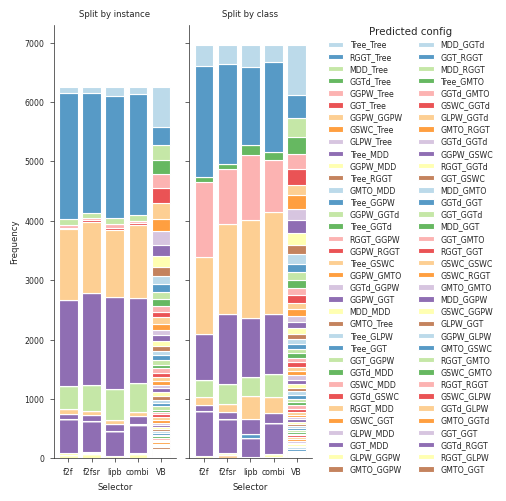

In [10]:
sns.set(**seaborn_opts)
fg = sns.displot(
    tally,x='featureset',weights='freq',multiple='stack',col='split',
    hue='pred_encs',
    col_order=['instance','class'],
    shrink=0.8, height=5, aspect=0.32,facet_kws=dict(legend_out=False),
    palette=pal(len(tencs_sorted))
)
fg.set_titles("Split by {col_name}")
fg.set_axis_labels("Selector","Frequency")
sns.move_legend(fg, loc='center left', bbox_to_anchor=(1,0.5), frameon=False, ncols=2,
               title="Predicted config", labelspacing=0.4, title_fontsize='large')
fg.tight_layout()
fg.savefig(FIGOUT,dpi=1200)

In [11]:
freqs = tally.copy()
freqs['li_pred'] = freqs.pred_encs.str.extract(r'^([^_]+)_')
freqs['pb_pred'] = freqs.pred_encs.str.extract(r'_([^_]+)$')

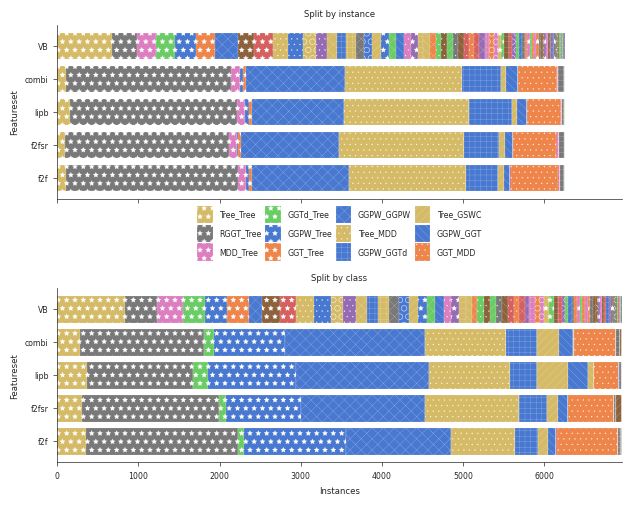

In [12]:
encs_cats = freqs.pred_encs.cat.categories
popular_encs = freqs.groupby(['pred_encs'])['freq'].max().reset_index().sort_values('freq')['pred_encs'].tolist()[-12:]
lis = freqs.li_pred.unique().tolist()
pbs = freqs.pb_pred.unique().tolist()

fig,axs=plt.subplots(2,1,figsize=(WID,0.8*WID), sharex=True)

hatch_pal = ['xxx', '\\\\\\\\', '+++', '---', '**', '////', '...', 'OO', '**' ]
color_pal = sns.color_palette("muted",len(freqs.li_pred.unique()))

for row, split in enumerate(['instance','class']):
    ax = axs[row]
    prev_data = None # for stacking
    for e, encs in enumerate(encs_cats):
        encs_label = encs if (encs in popular_encs) else f"_{encs}"
        li_enc, pb_enc = encs.split('_')
        data_avail = freqs.loc[(freqs.split==split)&(freqs.pred_encs==encs),['featureset','freq']]
        df_all_selectors = pd.DataFrame({'featureset':freqs.featureset.cat.categories})
        data = df_all_selectors.merge(data_avail, on='featureset',how='left').fillna(0)
        ax.invert_yaxis()
        ax.set(title=f"Split by {split}",
               xlabel="Instances" if row==1 else None, ylabel="Featureset")
        ax.barh(data.featureset, data.freq, left=None if prev_data is None else prev_data.freq,
                label=encs_label,
                color=color_pal[lis.index(li_enc)],
                hatch=hatch_pal[pbs.index(pb_enc)],
                linewidth=0.1,edgecolor='w')
        plt.rc("hatch",lw=0.1,color='k')
        if prev_data is None:
            prev_data = data.copy()
        else:
            prev_data['freq'] = prev_data.freq + data.freq
    if row==0:
        ax.legend(bbox_to_anchor=(0.5,0),loc='upper center',
                  ncols=4,frameon=False,labelspacing=0.2,handleheight=3,columnspacing=0.5)
sns.despine(fig)
fig.tight_layout()
fig.savefig("/tmp/pred-stacks.pdf", dpi=1200)

In [7]:
color_pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

In [8]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#